In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import pandas as pd

# ==== 0) Parâmetros ====
ARQ_IN    = "Matrix.csv"        # saída do passo anterior (pivot pronto)
OUT_W     = "W_frames.csv"      # pesos por frame (frames × K)
OUT_H     = "H_padroes.csv"     # padrões (K × células)
OUT_TOP   = "frames_tipicos_CNN_KMEANS.csv"
SEED      = 42
MAX_ITER  = 2000

# Ler a matriz W gerada pelo NMF (output do passo anterior)
df_W = pd.read_csv("nmf_output_W.csv", index_col=0)

print(f"✅ df_W carregado: {df_W.shape[0]} frames × {df_W.shape[1]} padrões")
df_W.head()


✅ df_W carregado: 1016 frames × 16 padrões


,padrao_1,padrao_2,padrao_3,padrao_4,padrao_5,padrao_6,padrao_7,padrao_8,padrao_9,padrao_10,padrao_11,padrao_12,padrao_13,padrao_14,padrao_15,padrao_16
timestamp,,,,,,,,,,,,,,,,
1900-01-01 00:00:00.852,8.795910e-175,0.000000e+00,7.816144e-113,3.312757e-105,2.417460e+00,0.000000e+00,1.842526e-295,2.031529e-93,8.003952e-111,2.114985e-156,5.547209e-01,1.653891e-22,0.000000e+00,0.000000e+00,0.000000e+00,9.030050e-60
1900-01-01 00:00:03.401,2.008556e-118,0.000000e+00,1.043267e-65,1.591409e-48,3.071561e-63,0.000000e+00,1.011227e-114,7.682763e-40,8.999235e-01,2.643491e-01,4.876895e-76,0.000000e+00,2.480880e-44,0.000000e+00,1.708660e-103,1.659116e+00
1900-01-01 00:00:05.246,1.765179e-110,5.427120e-160,7.141552e-164,2.086757e-134,1.303124e-48,3.142231e+00,0.000000e+00,1.855168e-58,4.940969e-01,5.084288e-57,3.468446e-154,4.577991e-16,0.000000e+00,0.000000e+00,1.813613e-93,1.218121e-78
1900-01-01 00:00:07.974,0.000000e+00,0.000000e+00,1.647845e+00,1.380885e-72,2.770991e-98,0.000000e+00,1.895330e-107,0.000000e+00,1.461044e-114,2.536591e-79,2.911625e-26,1.563063e-13,7.553630e-298,1.764106e-109,9.031715e-95,8.373649e-152
1900-01-01 00:00:08.614,6.948457e-01,1.020781e-31,0.000000e+00,3.975726e-01,0.000000e+00,5.382901e-26,3.525701e-01,5.852338e-118,1.581834e-101,0.000000e+00,1.249196e-55,1.842912e-79,3.746755e-01,0.000000e+00,4.203163e-01,0.000000e+00


In [3]:
# Normalizar W para [0,1] (necessário porque o decoder termina em Sigmoid)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_W)

# Redimensionar para formato (frames, canais, padrões)
X_scaled = np.expand_dims(X_scaled, axis=1)

# Converter em tensor PyTorch
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


# Autoencoder → input = output
dataset = TensorDataset(X_tensor, X_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

print("Dados normalizados e loader pronto:", X_tensor.shape)

Dados normalizados e loader pronto: torch.Size([1016, 1, 16])


In [4]:
# === Definir CNN Autoencoder robusta ===
import torch.nn as nn

class CNNAutoencoder(nn.Module):
    def __init__(self, input_len=10, embedding_dim=64):
        super(CNNAutoencoder, self).__init__()
        
        # ----- ENCODER -----
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.AdaptiveAvgPool1d(1)   # condensa cada filtro num valor
        )
        self.fc_enc = nn.Linear(128, embedding_dim)   # embedding final

        # ----- DECODER -----
        self.fc_dec = nn.Linear(embedding_dim, 128)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            
            nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.ConvTranspose1d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()  # saída [0,1]
        )
        
    def forward(self, x):
        # Encoder
        x = self.encoder(x)            
        x = x.view(x.size(0), -1)     
        z = self.fc_enc(x)            # embeddings
        
        # Decoder
        x = self.fc_dec(z)            
        x = x.view(x.size(0), 128, 1) 
        x = self.decoder(x)           
        return z, x

# Instanciar modelo
embedding_dim = 64
model = CNNAutoencoder(input_len=10, embedding_dim=embedding_dim)


In [5]:
# === Treino com Early Stopping ===
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 200
patience = 15
best_loss = float("inf")
trigger = 0

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for X_batch, _ in loader:
        optimizer.zero_grad()
        z, X_recon = model(X_batch)
        loss = criterion(X_recon, X_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(loader)
    print(f"Época {epoch+1}/{EPOCHS}, Loss médio={avg_loss:.6f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print("⏹ Early stopping ativado!")
            break


/Users/rr/.pyenv/versions/3.11.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([32, 1, 16])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rr/.pyenv/versions/3.11.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([24, 1, 16])) that is different to the input size (torch.Size([24, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Época 1/200, Loss médio=0.227343
Época 2/200, Loss médio=0.124790
Época 3/200, Loss médio=0.053873
Época 4/200, Loss médio=0.031231
Época 5/200, Loss médio=0.024163
Época 6/200, Loss médio=0.020900
Época 7/200, Loss médio=0.019449
Época 8/200, Loss médio=0.018544
Época 9/200, Loss médio=0.017940
Época 10/200, Loss médio=0.017361
Época 11/200, Loss médio=0.017039
Época 12/200, Loss médio=0.016733
Época 13/200, Loss médio=0.016593
Época 14/200, Loss médio=0.016372
Época 15/200, Loss médio=0.016362
Época 16/200, Loss médio=0.016354
Época 17/200, Loss médio=0.016260
Época 18/200, Loss médio=0.016227
Época 19/200, Loss médio=0.016133
Época 20/200, Loss médio=0.016160
Época 21/200, Loss médio=0.016128
Época 22/200, Loss médio=0.016090
Época 23/200, Loss médio=0.016085
Época 24/200, Loss médio=0.016114
Época 25/200, Loss médio=0.016053
Época 26/200, Loss médio=0.016046
Época 27/200, Loss médio=0.016025
Época 28/200, Loss médio=0.016051
Época 29/200, Loss médio=0.016082
Época 30/200, Loss médi

In [6]:
# === Extrair embeddings ===
embeddings = []
with torch.no_grad():
    for X_batch, _ in loader:
        z, _ = model(X_batch)    # z = embedding
        embeddings.append(z.numpy())

embeddings = np.vstack(embeddings)
print("Embeddings shape:", embeddings.shape)


Embeddings shape: (1016, 64)


In [7]:
embeddings

array([[ 0.6535153 ,  0.42327738,  0.17515177, ..., -0.02075008,
        -0.12296426,  1.0362842 ],
       [ 0.35724413,  0.14756973,  0.09256062, ..., -0.16952017,
        -0.01380911,  0.53039855],
       [ 0.08532158, -0.28500375,  0.20948945, ..., -0.18523546,
        -0.06871644, -0.22082976],
       ...,
       [ 0.12293059, -0.34287092,  0.14606126, ..., -0.22927706,
        -0.12863316, -0.20784971],
       [ 0.36231637, -0.14763895,  0.2666267 , ..., -0.21867195,
        -0.17669433,  0.2061621 ],
       [ 0.41994557, -0.01867147,  0.20495926, ..., -0.26402506,
        -0.30212146,  0.2845606 ]], shape=(1016, 64), dtype=float32)

Shape dos embeddings: (1016, 64)
➡️ Nº de clusters escolhido pelo cotovelo da inércia: 3


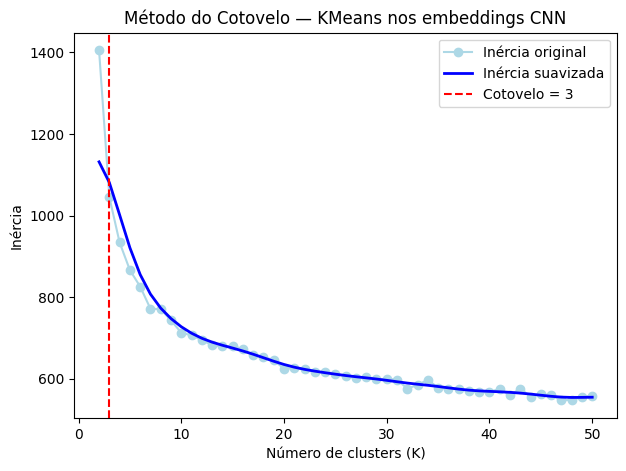

In [ ]:
# ==============================================
# Clustering com MiniBatchKMeans — apenas inércia
# ==============================================
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ---- Garantir que tens os embeddings ----
print("Shape dos embeddings:", embeddings.shape)

# ---- Definir intervalo de K ----
max_k = min(50, embeddings.shape[0])   # não pode ultrapassar nº de frames
Ks, inertias = [], []

# ---- Loop de clustering ----
for k in range(2, max_k+1):
    km = MiniBatchKMeans(
        n_clusters=k,
        random_state=SEED,
        batch_size=128,
        n_init=10
    )
    km.fit(embeddings)
    Ks.append(k)
    inertias.append(km.inertia_)

# ---- Converter listas para arrays ----
inertias = np.array(inertias)

# ---- Suavizar curva da inércia ----
inertias_smooth = gaussian_filter1d(inertias, sigma=2)

# ---- Critério do cotovelo (queda relativa) ----
drops = np.r_[np.nan, -(np.diff(inertias_smooth))]
rel = drops / np.r_[np.nan, inertias_smooth[:-1]]
limite = 0.05  # 5%
idx = np.where(rel < limite)[0]
K_cotovelo = Ks[idx[0]] if len(idx) else Ks[np.argmin(inertias_smooth)]

print(f"➡️ Nº de clusters escolhido pelo cotovelo da inércia: {K_cotovelo}")

# ---- Cluster final ----
kmeans_final = MiniBatchKMeans(
    n_clusters=K_cotovelo,
    random_state=SEED,
    batch_size=128,
    n_init=10
)
labels_final = kmeans_final.fit_predict(embeddings)

df_clusters = pd.DataFrame({
    "timestamp": df_W.index,
    "cluster": labels_final
})

# ---- Gráfico da inércia ----
plt.figure(figsize=(7,5))
plt.plot(Ks, inertias, marker="o", color="lightblue", label="Inércia original")
plt.plot(Ks, inertias_smooth, color="blue", linewidth=2, label="Inércia suavizada")
plt.axvline(K_cotovelo, color="red", linestyle="--", label=f"Cotovelo = {K_cotovelo}")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inércia")
plt.title("Método do Cotovelo — KMeans nos embeddings CNN")
plt.legend()
plt.grid(False)
plt.show()


In [9]:
# ==== Aplicar K-Means final em W (usando K do cotovelo) ====
kmeans = MiniBatchKMeans(
    n_clusters=K_cotovelo,
    random_state=SEED,
    batch_size=128,
    n_init=10
)
labels = kmeans.fit_predict(embeddings)


df_clusters = df_W.copy()
df_clusters["cluster"] = labels
df_clusters["timestamp"] = df_W.index

print("Clusters atribuídos:")
display(df_clusters)

print("\nDistribuição por cluster:")
print(df_clusters["cluster"].value_counts())


Clusters atribuídos:


,padrao_1,padrao_2,padrao_3,padrao_4,padrao_5,padrao_6,padrao_7,padrao_8,padrao_9,padrao_10,padrao_11,padrao_12,padrao_13,padrao_14,padrao_15,padrao_16,cluster,timestamp
timestamp,,,,,,,,,,,,,,,,,,
1900-01-01 00:00:00.852,8.795910e-175,0.000000e+00,7.816144e-113,3.312757e-105,2.417460e+00,0.000000e+00,1.842526e-295,2.031529e-93,8.003952e-111,2.114985e-156,5.547209e-01,1.653891e-22,0.000000e+00,0.000000e+00,0.000000e+00,9.030050e-60,1,1900-01-01 00:00:00.852
1900-01-01 00:00:03.401,2.008556e-118,0.000000e+00,1.043267e-65,1.591409e-48,3.071561e-63,0.000000e+00,1.011227e-114,7.682763e-40,8.999235e-01,2.643491e-01,4.876895e-76,0.000000e+00,2.480880e-44,0.000000e+00,1.708660e-103,1.659116e+00,2,1900-01-01 00:00:03.401
1900-01-01 00:00:05.246,1.765179e-110,5.427120e-160,7.141552e-164,2.086757e-134,1.303124e-48,3.142231e+00,0.000000e+00,1.855168e-58,4.940969e-01,5.084288e-57,3.468446e-154,4.577991e-16,0.000000e+00,0.000000e+00,1.813613e-93,1.218121e-78,0,1900-01-01 00:00:05.246
1900-01-01 00:00:07.974,0.000000e+00,0.000000e+00,1.647845e+00,1.380885e-72,2.770991e-98,0.000000e+00,1.895330e-107,0.000000e+00,1.461044e-114,2.536591e-79,2.911625e-26,1.563063e-13,7.553630e-298,1.764106e-109,9.031715e-95,8.373649e-152,2,1900-01-01 00:00:07.974
1900-01-01 00:00:08.614,6.948457e-01,1.020781e-31,0.000000e+00,3.975726e-01,0.000000e+00,5.382901e-26,3.525701e-01,5.852338e-118,1.581834e-101,0.000000e+00,1.249196e-55,1.842912e-79,3.746755e-01,0.000000e+00,4.203163e-01,0.000000e+00,2,1900-01-01 00:00:08.614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900-01-01 00:48:50.491,1.584780e-167,1.443501e+00,0.000000e+00,2.797079e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.742791e-210,0.000000e+00,0.000000e+00,0.000000e+00,0,1900-01-01 00:48:50.491
1900-01-01 00:48:52.648,2.265944e-60,1.331817e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.578689e-57,4.985501e-01,1.185008e-94,0.000000e+00,0.000000e+00,8.066338e-90,9.474197e-306,3.646019e-131,0.000000e+00,8.112271e-57,0.000000e+00,2,1900-01-01 00:48:52.648
1900-01-01 00:49:02.726,0.000000e+00,1.232208e+00,0.000000e+00,9.563873e-160,3.811870e-173,0.000000e+00,0.000000e+00,1.090860e-54,1.012674e-86,1.794959e-180,1.664136e-126,7.996334e-01,7.302053e-35,0.000000e+00,5.471053e-41,0.000000e+00,0,1900-01-01 00:49:02.726



Distribuição por cluster:
cluster
0    466
2    385
1    165
Name: count, dtype: int64


In [10]:
from sklearn.metrics import pairwise_distances_argmin_min

# índices dos medoids (mais próximos dos centros dos clusters)
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, embeddings)

# marcar medoids
df_clusters["is_medoid"] = False
df_clusters.iloc[closest, df_clusters.columns.get_loc("is_medoid")] = True

# mostrar resultados
medoids = df_clusters[df_clusters["is_medoid"]][["timestamp", "cluster"]]
print("Timestamps mais representativos (medoids):")
display(medoids)


Timestamps mais representativos (medoids):


,timestamp,cluster
timestamp,,
1900-01-01 00:02:57.566,1900-01-01 00:02:57.566,0
1900-01-01 00:27:06.868,1900-01-01 00:27:06.868,2
1900-01-01 00:37:36.595,1900-01-01 00:37:36.595,1


In [11]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# ==== Métricas de clusterização ====
X_features = embeddings               # usa embeddings do Autoencoder CNN
labels = df_clusters["cluster"].values  

silhouette = silhouette_score(X_features, labels)        # [-1, 1]; >0.3 já é razoável
davies     = davies_bouldin_score(X_features, labels)   # menor é melhor (~1 bom)
calinski   = calinski_harabasz_score(X_features, labels) # maior é melhor

print("📊 Métricas de clusterização (KMeans em embeddings CNN)")
print(f"Silhouette Score:        {silhouette:.4f}")
print(f"Davies-Bouldin Index:    {davies:.4f}")
print(f"Calinski-Harabasz Index: {calinski:.4f}")


📊 Métricas de clusterização (KMeans em embeddings CNN)
Silhouette Score:        0.3243
Davies-Bouldin Index:    1.1577
Calinski-Harabasz Index: 835.4308


In [12]:
# ==== Exportar frames típicos (medoids) ====
medoids = df_clusters.loc[df_clusters["is_medoid"], ["timestamp", "cluster"]]

medoids.to_csv(OUT_TOP, index=False)

print("Frames típicos (medoids) exportados para:", OUT_TOP)
display(medoids)


Frames típicos (medoids) exportados para: frames_tipicos_CNN_KMEANS.csv


,timestamp,cluster
timestamp,,
1900-01-01 00:02:57.566,1900-01-01 00:02:57.566,0
1900-01-01 00:27:06.868,1900-01-01 00:27:06.868,2
1900-01-01 00:37:36.595,1900-01-01 00:37:36.595,1
